In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import os
import random
from sklearn.model_selection import train_test_split

from utils import *
from architectures_v1 import *
from datasets import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN, TimeDistributed, GRU, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
def pend(x, t, u, b, c):
    x1, x2 = x
    dxdt = [x2, -b*x2 - c*np.sin(x1) + u]
    return dxdt

def fluid_flow(x, t, u, mu, omega, A, l):
    x1, x2, x3 = x 
    dxdt = [mu*x1 - omega*x1 + A*x1*x3 + u,
           omega*x1 - omega*x2 + A*x2*x3,
           -l*(x3 - x1**2 - x2**2)]
    return dxdt

In [3]:
# Function to generate input/output data
def generate_data_IO(t, n_instances, n_states, dyn_system = "Pendulum", **kwargs):
    
    if dyn_system == "Pendulum":
        if 'b' not in kwargs.keys() or 'c' not in kwargs.keys():
            b = 0.5
            c = 1.0
        else:
            b = kwargs['b']
            c = kwargs['c']
    elif dyn_system == "FluidFlow":
        if 'mu' not in kwargs.keys() or 'omega' not in kwargs.keys() or 'A' not in kwargs.keys() or 'l' not in kwargs.keys():
            mu = 0.1
            omega = 1.0
            A = -0.1
            l = 10
        else:
            mu = kwargs['mu']
            omega = kwargs['omega']
            A = kwargs['A']
            l = kwargs['l']

    # Creating containers for the inputs and the outputs (i.e., random inputs and states) given a number of instances
    Y = np.zeros(shape = (n_instances, t.shape[0], n_states))

    # Container for inputs to the NN
    X = np.zeros(shape = (n_instances, t.shape[0], n_states))

    for n_inst in range(n_instances):

        u = np.random.rand(t.shape[0], )

        # Creating random initial state
        x0 = np.random.rand(n_states, )

        X[n_inst, 0, :] = x0
        Y[0, 0, :] = x0

        for k in range(len(t) - 1):

            # Integration time
            t_int = np.linspace(t[k], t[k+1], 500)
            
            if dyn_system == "Pendulum":
                # Integration
                x_int = odeint(pend, x0, t_int, args = (u[k], b, c))
            elif dyn_system == "FluidFlow":
                # Integration
                x_int = odeint(fluid_flow, x0, t_int, args = (u[k], mu, omega, A, l))
                
            # Extracting the outputs
            for state in range(x_int.shape[-1]):
                Y[n_inst, k+1, state] = x_int[-1, state]

            # Updating initial condition for next integration
            x0 = x_int[-1, :]

        # Storing input in container for NN input
        X[n_inst, 1:, 0] = u[:k+1]
    
    return X, Y

t = np.linspace(0, 20, 200)
dt = max(t)/len(t)

X, Y = generate_data_IO(t = t, n_instances = 100, n_states = 3, dyn_system = "FluidFlow")
print(f"X: {X.shape}")
print(f"Y: {Y.shape}")

X: (100, 200, 3)
Y: (100, 200, 3)


In [4]:
X_train = np.reshape(X[0, :, :], [1, X.shape[1], X.shape[-1]])
X_test = np.reshape(X[1, :, :], [1, X.shape[1], X.shape[-1]])
X_valid = np.reshape(X[-1, :, :], [1, X.shape[1], X.shape[-1]])

Y_train = np.reshape(Y[0, :, :], [1, Y.shape[1], Y.shape[-1]])
Y_test = np.reshape(Y[1, :, :], [1, Y.shape[1], Y.shape[-1]])
Y_valid = np.reshape(Y[-1, :, :], [1, Y.shape[1], Y.shape[-1]])

print(f"X_train: {X_train.shape} - Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape} - Y_test: {Y_test.shape}")
print(f"X_valid: {X_valid.shape} - Y_valid: {Y_valid.shape}")

X_train: (1, 200, 3) - Y_train: (1, 200, 3)
X_test: (1, 200, 3) - Y_test: (1, 200, 3)
X_valid: (1, 200, 3) - Y_valid: (1, 200, 3)


In [5]:
n_instances = X.shape[0]
n_validation = int(0.1*X.shape[0])
ind_validation = random.sample(range(0, n_instances), n_validation)

X_valid = X[ind_validation, :, :]
Y_valid = Y[ind_validation, :, :]

X_all = np.delete(X, ind_validation, axis = 0)
Y_all = np.delete(Y, ind_validation, axis = 0)

X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size = 0.2, random_state = 42)

print(f"X_train: {X_train.shape} - Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape} - Y_test: {Y_test.shape}")
print(f"X_valid: {X_valid.shape} - Y_valid: {Y_valid.shape}")

X_train: (72, 200, 3) - Y_train: (72, 200, 3)
X_test: (18, 200, 3) - Y_test: (18, 200, 3)
X_valid: (10, 200, 3) - Y_valid: (10, 200, 3)


In [6]:
# Setting seed
seed = 42
tf.random.set_random_seed(seed)
np.random.seed(seed)

model = Sequential()


# This is the line of code that changes
model.add(RNN(OrthogonalCell(units = 212,
                             order = 256,
                             variant = "ct_laguerre",
                             dt = dt,
                            input_dims = X_train.shape[-1]), 
              input_shape = (X_train.shape[1], X_train.shape[-1]),
             return_sequences = True))
model.add(TimeDistributed(Dense(3)))
# does not make sense to use metrics=['acc'], see https://stackoverflow.com/questions/41819457/zero-accuracy-training-a-neural-network-in-keras
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 200, 212)          167145    
_________________________________________________________________
time_distributed (TimeDistri (None, 200, 3)            639       
Total params: 167,784
Trainable params: 101,474
Non-trainable params: 66,310
_________________________________________________________________


In [7]:
model_dir = os.path.abspath('sysid_test_laguerre')

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
# Setting seed
seed = 42
tf.random.set_random_seed(seed)
np.random.seed(seed)

file_path = os.path.join(model_dir, 'Laguerre_Model_SysID.hdf5') 
callbacks = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 0),
 EarlyStopping(monitor = 'val_loss', patience = 500, mode = 'min'),
 ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 50, min_lr = 0.0001)]

hist = model.fit(X_train, Y_train, 
                 epochs = 1, batch_size = 20, 
                 callbacks = callbacks, 
                 validation_data = (X_valid, Y_valid),
                 verbose = 1)

Train on 72 samples, validate on 10 samples
72/72 [==============================] - 1s 13ms/sample - loss: 0.1297 - mean_squared_error: 0.1297 - val_loss: 0.0380 - val_mean_squared_error: 0.0380


In [10]:
mse

0.061904046684503555

In [8]:
df_results = pd.DataFrame(hist.history)

# Computing epoch for best model
epoch_best =  np.argmin(df_results['mean_squared_error'].values)
# Determining MSE
mse = df_results['mean_squared_error'][epoch_best]

NameError: name 'Y_predict' is not defined

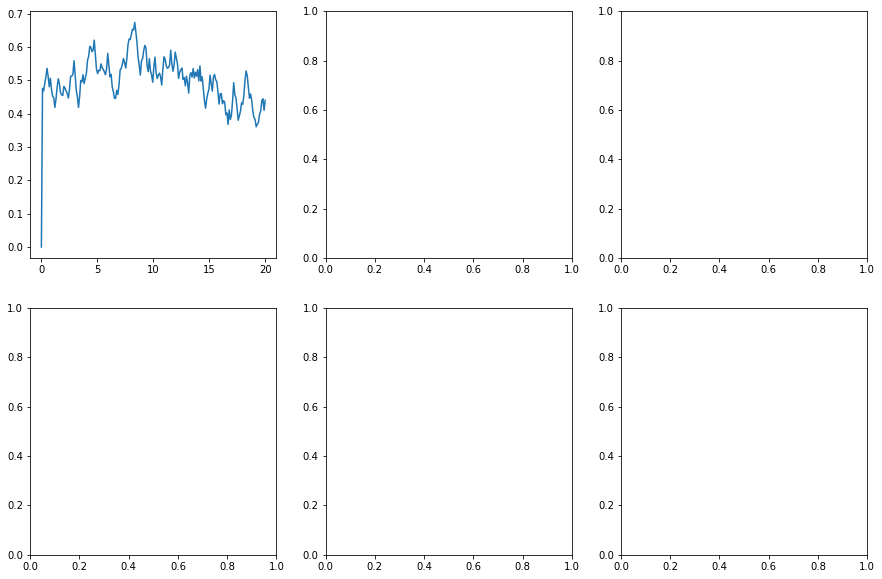

In [9]:
fig, axes = plt.subplots(figsize = (15, 10), nrows = 2, ncols = 3)

axes[0][0].plot(t, Y_test[-1,:, 0], label = "Ground Truth")
axes[0][0].plot(t, Y_predict[-1,:,0], label = "Prediction")
axes[0][0].legend()

# State 2
axes[0][1].plot(t, Y_test[0, :, 1], label = "Ground Truth")
axes[0][1].plot(t, Y_predict[0,:,1], label = "Prediction")
axes[0][1].legend()

# State 3
axes[0][2].plot(t, Y_test[-1, :, 2], label = "Ground Truth")
axes[0][2].plot(t, Y_predict[-1,:,2], label = "Prediction")
axes[0][2].legend()

# Loss function
axes[1][0].plot(epochs, loss, label = "Loss")
axes[1][1].plot(epochs, val_loss, label = "Validation Loss")

In [10]:
mu = 0.1
omega = 1.0
A = -0.1
l = 10

t = np.linspace(0, 60, 200)

u = np.ones(t.shape[0], )
x0 = np.random.rand(3, )

Y = np.zeros(shape = (1, len(t), 3))
Y[0, 0, :] = np.zeros(3, )

for k in range(len(t) - 1):

    # Integration time
    t_int = np.linspace(t[k], t[k+1], 200)

    # Integration
    x_int = odeint(fluid_flow, x0, t_int, args = (u[k], mu, omega, A, l))

    # Extracting the outputs
    for state in range(x_int.shape[-1]):
        Y[0, k+1, state] = x_int[-1, state]

    # Updating initial condition for next integration
    x0 = x_int[-1, :]

In [11]:
Y.shape

(1, 200, 3)

In [12]:
t = np.linspace(0, 60, 200)

#x0 = np.random.rand(2, )

U_step = np.zeros(shape = (t.shape[0], 3))
U_step[0,:] = x0

U_step[1:, 0] = np.ones(shape = (t.shape[0]-1, ))
U_step = np.reshape(U_step, [1, U_step.shape[0], U_step.shape[1]])

# Computing step response
Y_step_predict = model.predict(U_step)

In [111]:
Y.shape

(1, 200, 3)

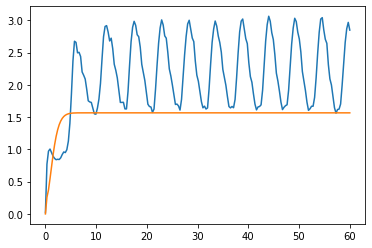

In [109]:
plt.plot(t, Y_step_predict[0,:,2])
plt.plot(t, Y[0, :, 2])
#plt.plot(t, Y_step_predict[0,:,1])
